# Lipid fingerprint analysis

This script analyzes membrane-protein or membrane-peptide MD trajectories and studies the protein-lipid interactions, including:

- Density maps --> GROMACS densmap of lipids in the XY plane

- DE index --> MDAnalysis of the depletion-enrichment index

- Occupancy --> % time a residue has been in contact w/ an specific lipid (headgroup)

- Residence time --> PyLipid analysis of theaverage residence time of a given lipid (headgroup)

- Pocket prediction --> prediction of pockets, residence times, occupancies, etc


## Import modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import pandas as pd
import seaborn as sns
import re
from scipy.ndimage.filters import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mdtraj
import MDAnalysis as mda
from MDAnalysis.analysis.density import DensityAnalysis
import lipyphilic
from lipyphilic.lib.area_per_lipid import AreaPerLipid
from lipyphilic.lib.memb_thickness import MembThickness
from lipyphilic.lib.assign_leaflets import AssignLeaflets
import pylipid
from pylipid.api import LipidInteraction


Bad key text.latex.preview in file /home/apmlab/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.6.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/apmlab/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.6.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/apmlab/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default qualit

# Create folders

In [2]:
try:
    os.mkdir("Data_Analysis")
    print("Folder Data_Analysis created")
except OSError as error:
    print("Can't create folder: folder Data_Analysis already exists")

Can't create folder: folder Data_Analysis already exists


### 1.- Assign variables

In [92]:
prefix = "../Sample_files/TRPV2_test/" #File location
traj_file = f"{prefix}centered_step7_production.xtc" #Trajectory file
top_file = f"{prefix}step7_production.tpr" #Topology file
top_file_2 = f"{prefix}step6.6_equilibration.gro" #Topology file 2
index = f"{prefix}index.ndx" #Index file

in_memory = True #Load all trajectory to the memory?
memory_step = 10 #Memory step to load if in_memory=True

lipid_list = ["CHOL", "POPC", "PAPC", "PAPE", "DPSM", "PNGS", "POPA", "PAP1", "PAP6"] #List of lipids in the system
analysis_lipids = ["PAP6", "CHOL", "POPA", "PAP1"] #List of lipids of interest for itneractions and pocket finding

contact_cutoff = 7 #Assign a cutoff value for the contacts (A)
target = "protein" #Assign target to calculate contacts

window = 10 #Window size for the sliding window averages

### 2.- Load trajectory and preparations

In [4]:
#Load trajectory as MDA universe object
u = mda.Universe(top_file, traj_file, in_memory=in_memory, in_memory_step=memory_step)

#Store times from each frame of the trajectory
times = [ts.time for ts in u.trajectory]

print("Loaded trajectory: {}".format(u))
print("Number of frames: {}".format(len(u.trajectory)))


MDAnalysis.topology.TPRparser: INFO     Gromacs version   : b'VERSION 2021.2-MODIFIED'
MDAnalysis.topology.TPRparser: INFO     Gromacs version   : b'VERSION 2021.2-MODIFIED'
MDAnalysis.topology.TPRparser: INFO     tpx version       : 122
MDAnalysis.topology.TPRparser: INFO     tpx version       : 122
MDAnalysis.topology.TPRparser: INFO     tpx generation    : 28
MDAnalysis.topology.TPRparser: INFO     tpx generation    : 28
MDAnalysis.topology.TPRparser: INFO     tpx precision     : 4
MDAnalysis.topology.TPRparser: INFO     tpx precision     : 4
MDAnalysis.topology.TPRparser: INFO     tpx file_tag      : b'release'
MDAnalysis.topology.TPRparser: INFO     tpx file_tag      : b'release'
MDAnalysis.topology.TPRparser: INFO     tpx natoms        : 92998
MDAnalysis.topology.TPRparser: INFO     tpx natoms        : 92998
MDAnalysis.topology.TPRparser: INFO     tpx ngtc          : 3
MDAnalysis.topology.TPRparser: INFO     tpx ngtc          : 3
MDAnalysis.topology.TPRparser: INFO     tpx fep_st

Loaded trajectory: <Universe with 92998 atoms>
Number of frames: 473


### 3.- Generate density maps

In [8]:
try:
    os.mkdir("Data_Analysis/Densmaps")
    print("Folder Densmaps created")
except OSError as error:
    print("Can't create folder: folder Densmaps already exists")

Folder Densmaps created


In [20]:
for lipid in lipid_list:
    densmap = f'echo {lipid}| gmx densmap -f {traj_file} -s {top_file} -od ./Data_Analysis/Densmaps/{lipid}_densmap.dat'
    os.system(densmap)
os.system(f'echo Protein | gmx densmap -f {traj_file} -s {top_file} -od ./Data_Analysis/Densmaps/Protein_densmap.dat')

                      :-) GROMACS - gmx densmap, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/apmlab/Projectes/mario/Script_devel/Analysis_scripts
Command line:
  gmx densmap -f ../Sample_files/TRPV2_test/centered_step7_production.xtc -s ../Sample_files/TRPV2_test/step7_production.tpr -od ./Data_Analysis/Densmaps/CHOL_densmap.dat

Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)
Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)

Select an analysis group
Group     0 (         System) has 92998 elements
Group     1 (        Protein) has  6320 elements
Group     2 (      Protein-H) has  6320 elements
Group     3 (        C-alpha) has     0 elements
Group     4 (       Backbone) has     0 elements
Group     5 (      MainChain) has     0 elements
Group     6 (   MainChain+Cb) has     0 elements
Group     7 (    MainChain+H)

Selected 13: 'CHOL'

  The maximum density is 0.969861 (nm^-3)


                      :-) GROMACS - gmx densmap, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/apmlab/Projectes/mario/Script_devel/Analysis_scripts
Command line:
  gmx densmap -f ../Sample_files/TRPV2_test/centered_step7_production.xtc -s ../Sample_files/TRPV2_test/step7_production.tpr -od ./Data_Analysis/Densmaps/POPC_densmap.dat

Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)
Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)

Select an analysis group
Group     0 (         System) has 92998 elements
Group     1 (        Protein) has  6320 elements
Group     2 (      Protein-H) has  6320 elements
Group     3 (        C-alpha) has     0 elements
Group     4 (       Backbone) has     0 elements
Group     5 (      MainChain) has     0 elements
Group     6 (   MainChain+Cb) has     0 elements
Group     7 (    MainChain+H)

Selected 14: 'POPC'

  The maximum density is 0.711280 (nm^-3)


                      :-) GROMACS - gmx densmap, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/apmlab/Projectes/mario/Script_devel/Analysis_scripts
Command line:
  gmx densmap -f ../Sample_files/TRPV2_test/centered_step7_production.xtc -s ../Sample_files/TRPV2_test/step7_production.tpr -od ./Data_Analysis/Densmaps/PAPC_densmap.dat

Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)
Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)

Select an analysis group
Group     0 (         System) has 92998 elements
Group     1 (        Protein) has  6320 elements
Group     2 (      Protein-H) has  6320 elements
Group     3 (        C-alpha) has     0 elements
Group     4 (       Backbone) has     0 elements
Group     5 (      MainChain) has     0 elements
Group     6 (   MainChain+Cb) has     0 elements
Group     7 (    MainChain+H)

Selected 15: 'PAPC'

  The maximum density is 0.409463 (nm^-3)


Reading frame    4000 time 4000000.000   

Back Off! I just backed up ./Data_Analysis/Densmaps/PAPE_densmap.dat to ./Data_Analysis/Densmaps/#PAPE_densmap.dat.1#

GROMACS reminds you: "If at one time or another I have brushed a few colleagues the wrong way, I must apologize: I had not realized that they were covered with fur." (Edwin Chargaff)

                      :-) GROMACS - gmx densmap, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/apmlab/Projectes/mario/Script_devel/Analysis_scripts
Command line:
  gmx densmap -f ../Sample_files/TRPV2_test/centered_step7_production.xtc -s ../Sample_files/TRPV2_test/step7_production.tpr -od ./Data_Analysis/Densmaps/DPSM_densmap.dat

Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)
Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)

Select an analysis group
Group     0 (         Syst

Selected 16: 'PAPE'

  The maximum density is 0.646695 (nm^-3)


Reading frame    4000 time 4000000.000   

Back Off! I just backed up ./Data_Analysis/Densmaps/DPSM_densmap.dat to ./Data_Analysis/Densmaps/#DPSM_densmap.dat.1#

GROMACS reminds you: "Energy is a very subtle concept. It is very, very difficult to get right." (Richard Feynman)

                      :-) GROMACS - gmx densmap, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/apmlab/Projectes/mario/Script_devel/Analysis_scripts
Command line:
  gmx densmap -f ../Sample_files/TRPV2_test/centered_step7_production.xtc -s ../Sample_files/TRPV2_test/step7_production.tpr -od ./Data_Analysis/Densmaps/PNGS_densmap.dat

Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)
Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)

Select an analysis group
Group     0 (         System) has 92998 elements
Group     1 (        Protein) has  6320 eleme

Selected 17: 'DPSM'

  The maximum density is 0.474152 (nm^-3)


Reading frame    4000 time 4000000.000   

Back Off! I just backed up ./Data_Analysis/Densmaps/PNGS_densmap.dat to ./Data_Analysis/Densmaps/#PNGS_densmap.dat.1#

GROMACS reminds you: "We Can Dance Like Iggy Pop" (Red Hot Chili Peppers)

                      :-) GROMACS - gmx densmap, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/apmlab/Projectes/mario/Script_devel/Analysis_scripts
Command line:
  gmx densmap -f ../Sample_files/TRPV2_test/centered_step7_production.xtc -s ../Sample_files/TRPV2_test/step7_production.tpr -od ./Data_Analysis/Densmaps/POPA_densmap.dat

Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)
Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)

Select an analysis group
Group     0 (         System) has 92998 elements
Group     1 (        Protein) has  6320 elements
Group     2 (      Protein-H) has  63

Selected 18: 'PNGS'

  The maximum density is 0.668423 (nm^-3)


Reading frame    4000 time 4000000.000   

Back Off! I just backed up ./Data_Analysis/Densmaps/POPA_densmap.dat to ./Data_Analysis/Densmaps/#POPA_densmap.dat.1#

GROMACS reminds you: "When doing HPC, don't communica" (Jim Demmel)

                      :-) GROMACS - gmx densmap, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/apmlab/Projectes/mario/Script_devel/Analysis_scripts
Command line:
  gmx densmap -f ../Sample_files/TRPV2_test/centered_step7_production.xtc -s ../Sample_files/TRPV2_test/step7_production.tpr -od ./Data_Analysis/Densmaps/PAP1_densmap.dat

Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)
Reading file ../Sample_files/TRPV2_test/step7_production.tpr, VERSION 2021.2-MODIFIED (single precision)


Selected 21: 'POPA'

  The maximum density is 0.517289 (nm^-3)



Select an analysis group
Group     0 (         System) has 92998 elements
Group     1 (        Protein) has  6320 elements
Group     2 (      Protein-H) has  6320 elements
Group     3 (        C-alpha) has     0 elements
Group     4 (       Backbone) has     0 elements
Group     5 (      MainChain) has     0 elements
Group     6 (   MainChain+Cb) has     0 elements
Group     7 (    MainChain+H) has     0 elements
Group     8 (      SideChain) has  6320 elements
Group     9 (    SideChain-H) has  6320 elements
Group    10 (    Prot-Masses) has  6320 elements
Group    11 (    non-Protein) has 86678 elements
Group    12 (          Other) has 86678 elements
Group    13 (           CHOL) has  3808 elements
Group    14 (           POPC) has  2136 elements
Group    15 (           PAPC) has   546 elements
Group    16 (           PAPE) has  1755 elements
Group    17 (           DPSM) has   935 elements
Group    18 (           PNGS) has  1125 elements
Group    19 (           PAPS) has  2756 ele

Selected 22: 'PAP1'

  The maximum density is 0.732980 (nm^-3)



Select an analysis group
Group     0 (         System) has 92998 elements
Group     1 (        Protein) has  6320 elements
Group     2 (      Protein-H) has  6320 elements
Group     3 (        C-alpha) has     0 elements
Group     4 (       Backbone) has     0 elements
Group     5 (      MainChain) has     0 elements
Group     6 (   MainChain+Cb) has     0 elements
Group     7 (    MainChain+H) has     0 elements
Group     8 (      SideChain) has  6320 elements
Group     9 (    SideChain-H) has  6320 elements
Group    10 (    Prot-Masses) has  6320 elements
Group    11 (    non-Protein) has 86678 elements
Group    12 (          Other) has 86678 elements
Group    13 (           CHOL) has  3808 elements
Group    14 (           POPC) has  2136 elements
Group    15 (           PAPC) has   546 elements
Group    16 (           PAPE) has  1755 elements
Group    17 (           DPSM) has   935 elements
Group    18 (           PNGS) has  1125 elements
Group    19 (           PAPS) has  2756 ele

Selected 20: 'PAP6'

  The maximum density is 0.689821 (nm^-3)



Select an analysis group
Group     0 (         System) has 92998 elements
Group     1 (        Protein) has  6320 elements
Group     2 (      Protein-H) has  6320 elements
Group     3 (        C-alpha) has     0 elements
Group     4 (       Backbone) has     0 elements
Group     5 (      MainChain) has     0 elements
Group     6 (   MainChain+Cb) has     0 elements
Group     7 (    MainChain+H) has     0 elements
Group     8 (      SideChain) has  6320 elements
Group     9 (    SideChain-H) has  6320 elements
Group    10 (    Prot-Masses) has  6320 elements
Group    11 (    non-Protein) has 86678 elements
Group    12 (          Other) has 86678 elements
Group    13 (           CHOL) has  3808 elements
Group    14 (           POPC) has  2136 elements
Group    15 (           PAPC) has   546 elements
Group    16 (           PAPE) has  1755 elements
Group    17 (           DPSM) has   935 elements
Group    18 (           PNGS) has  1125 elements
Group    19 (           PAPS) has  2756 ele

Selected 1: 'Protein'

  The maximum density is 5.000828 (nm^-3)




GROMACS reminds you: "For a research worker the unforgotten moments of his life are those rare ones which come after years of plodding work, when the veil over natures secret seems suddenly to lift & when what was dark & chaotic appears in a clear & beautiful light & pattern." (Gerty Cori)



0

Plotting density map of maps
Density ./Data_Analysis/Densmaps/CHOL_densmap.dat


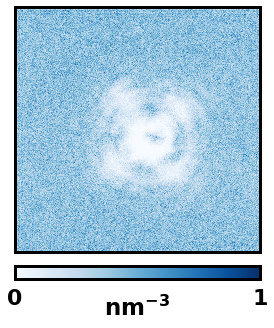

Plotting density map of maps
Density ./Data_Analysis/Densmaps/POPC_densmap.dat


<Figure size 432x288 with 0 Axes>

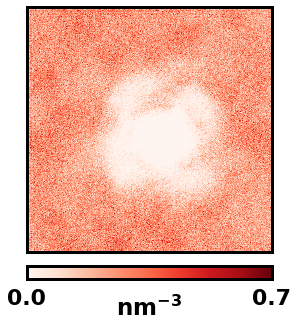

Plotting density map of maps
Density ./Data_Analysis/Densmaps/PAPC_densmap.dat


<Figure size 432x288 with 0 Axes>

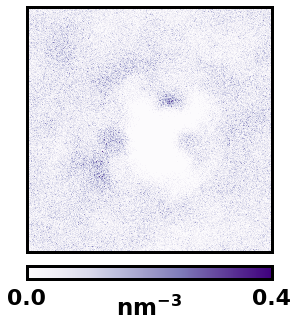

Plotting density map of maps
Density ./Data_Analysis/Densmaps/PAPE_densmap.dat


<Figure size 432x288 with 0 Axes>

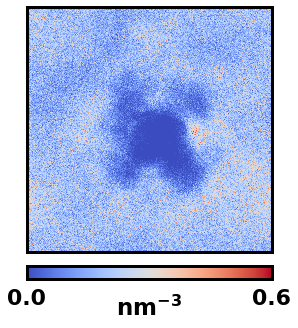

Plotting density map of maps
Density ./Data_Analysis/Densmaps/DPSM_densmap.dat


<Figure size 432x288 with 0 Axes>

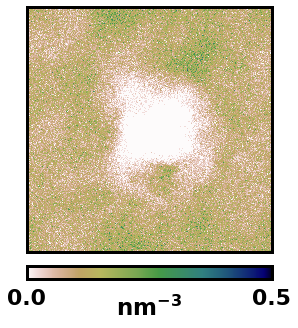

Plotting density map of maps
Density ./Data_Analysis/Densmaps/PNGS_densmap.dat


<Figure size 432x288 with 0 Axes>

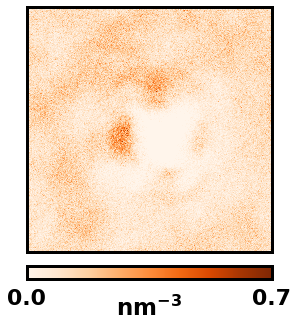

Plotting density map of maps
Density ./Data_Analysis/Densmaps/POPA_densmap.dat


<Figure size 432x288 with 0 Axes>

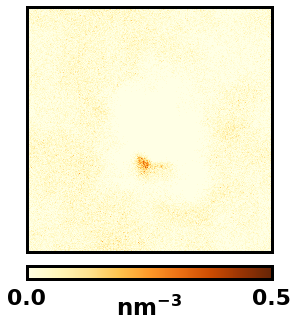

Plotting density map of maps
Density ./Data_Analysis/Densmaps/PAP1_densmap.dat


<Figure size 432x288 with 0 Axes>

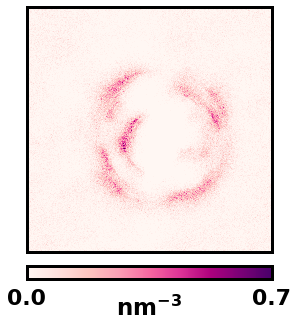

Plotting density map of maps
Density ./Data_Analysis/Densmaps/PAP6_densmap.dat


<Figure size 432x288 with 0 Axes>

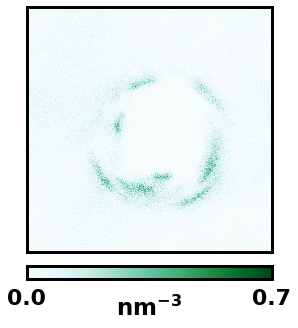

Plotting density map of maps
Density ./Data_Analysis/Densmaps/Protein_densmap.dat


<Figure size 432x288 with 0 Axes>

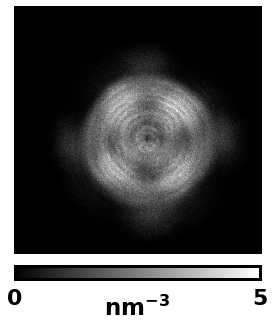

<Figure size 432x288 with 0 Axes>

In [21]:
#Define colors for each lipid
colors = ["Blues", "Reds", "Purples", "coolwarm", "gist_earth_r", "Oranges", "YlOrBr", "RdPu", "BuGn"]
color_map = {"tein": "gray"}; color_map.update({lipid:colors[i] for i,lipid in enumerate(lipid_list)})

#CALCULATE OVER THE MEAN [] of each lipid in the membrane?

#Plot densmaps
for densmap in glob.glob("./Data_Analysis/Densmaps/*.dat"):
    print('Plotting density map of ' + densmap[20:24])
    data = pd.read_csv(densmap, sep='\t', index_col=0)
    data = data.dropna(axis=1)

    data.index = [round(x) for x in data.index]
    data.columns = [round(float(x)) for x in data.columns]
    
    #Get min and max value of dataset
    max_val = data.max().max()
    min_val = data.min().min()
    
    #Create subplot and divide to operate heatmap and cbar separately more easily (cbar size = heatmap)
    fig, ax = plt.subplots(figsize=(5, 5))
    divider = make_axes_locatable(ax)

    cbar_ax = divider.new_vertical(size="5%", pad=0.2, pack_start=True)
    fig.add_axes(cbar_ax)
    
    #Create heatmap, put cbar in bottom, ensure it has aquare shape
    ax = sns.heatmap(data, ax=ax, cmap=color_map[densmap[-16:-12]], cbar_ax=cbar_ax, vmin=round(min_val,1), vmax=round(max_val,1),
                     cbar_kws={"orientation": "horizontal","ticks":[round(min_val,1),round(max_val,1)]}, square=True)
    ax.set(xticks=[], yticks=[])
    ax.tick_params(bottom=False, top=False)  # remove the ticks
    ax.set_aspect("equal") #Set aspect squared
    
    # Drawing the frame (border) to heat tmap
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)
       
    #Get cbar and put border, its size, remove ticks, set text size    
    cbar = ax.collections[0].colorbar
    cbar.set_label("$\mathbf{nm^{-3}}$", labelpad=-13, size=23, weight="bold")
    cbar.ax.tick_params(labelsize=22, length=0, pad=10)
    cbar.ax.set_frame_on(True)
               
    for _, spine in cbar.ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)                 

               
    plt.xticks(weight = 'bold') #Only cbar xticks, so we can set all bold
        
    #Save figure
    ax.get_figure()
    plt.savefig(f"{densmap[:-4]}.tiff", transparent=True, dpi=800)
    print(f"Density {densmap}")
    plt.show()
    plt.clf()

### 3.2 Generate radial distribution function

In [22]:
from MDAnalysis.analysis import rdf

dict_rdf = {}

for lipid in lipid_list:
    dict_rdf[lipid] = rdf.InterRDF(u.select_atoms("protein"), u.select_atoms(f"resname {lipid}"), nbins=75, range=(0.0, 70.0), verbose=True)

    dict_rdf[lipid].run()

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

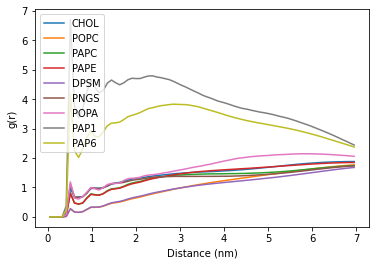

<Figure size 432x288 with 0 Axes>

In [23]:
df = pd.DataFrame(data={key:value.results.rdf for key, value in dict_rdf.items()})
df["bin"] = dict_rdf[lipid].results.bins/10

ax=sns.lineplot(data=df.melt(id_vars="bin"), x="bin", y="value", hue="variable")
plt.xlabel("Distance (nm)")
plt.ylabel("g(r)")
plt.legend(loc="best")
plt.show()
fig=ax.get_figure()
fig.savefig(f"./Data_Analysis/rdf.tiff", transparent=True, dpi=800)
plt.clf()

## 4.- Calculate average membrane thickness and curvature

### 4.1 Overall membrane thickness per frame

In [25]:
try:
    os.mkdir("Data_Analysis/Memb_thickness")
    print("Folder Memb_thickness created")
except OSError as error:
    print("Can't create folder: folder Memb_thickness already exists")

Folder Memb_thickness created


In [14]:
#First assign leaflets 
leaflets = AssignLeaflets(
  universe=u,
  lipid_sel="name AM1 AM2 GL1 GL2 ROH" # assuming we are using the MARTINI forcefield
)
leaflets.run()

lipid_set_noCHOL = set(lipid_list) - set(["CHOL", "PNGS"]) #Remove lipids without PO4
print(lipid_set_noCHOL)

#Determine overall thickness per frame
memb_thickness = MembThickness(
    universe=u,
    leaflets=leaflets.filter_leaflets(f"resname {' '.join(lipid_set_noCHOL)}"),  # exclude cholesterol from thickness calculation
    lipid_sel= f"resname {' '.join(lipid_set_noCHOL)} and name PO4" #Use PO4 to PO4 distance for thickness
)

memb_thickness.run(
  start=None,
  stop=None,
  step=None,
  verbose=True
)

{'POPC', 'DPSM', 'PAP1', 'POPA', 'PAPC', 'PAPE', 'PAP6'}


  0%|          | 0/473 [00:00<?, ?it/s]

/tmp/ipykernel_373068/1673747785.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')  ####### Style for the plots (defined one to keep same style accross ALL plots ########


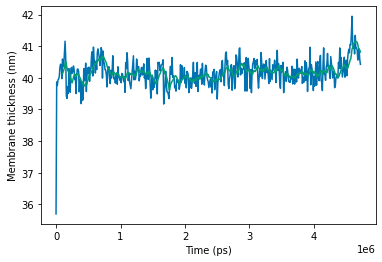

<Figure size 432x288 with 0 Axes>

In [33]:
#Calculate average mbr thickness over sliding window
mbr_thickness_avg = [None for n in range(window)]
avgs = [np.mean(memb_thickness.memb_thickness[(n-window):n]) for n in range((window+1),(window + 1 + len(memb_thickness.memb_thickness[window:])))] #Calculate avgs
mbr_thickness_avg.extend(avgs)

#Convert to df
data_for_df = {'Memb_thickness':memb_thickness.memb_thickness, 'Avg_memb_thickness':mbr_thickness_avg}
df = pd.DataFrame(index=times, data=data_for_df)

#Plot membrane thickness
plt.style.use('seaborn-colorblind')  ####### Style for the plots (defined one to keep same style accross ALL plots ########
sns_lipid = sns.lineplot(x=df.index, y='Memb_thickness', data=df)  # Plot term over time
sns_lipid = sns.lineplot(x=df.index, y='Avg_memb_thickness', data=df) #Plot avg thickness
sns_lipid.set_xlabel('Time (ps)')
y_ax_label = 'Membrane thickness (nm)'  # get y axis name based on term being plotted
sns_lipid.set_ylabel(y_ax_label)  # Change y axis label
fig = sns_lipid.get_figure()  # Get figure
output_name = './Data_Analysis/Memb_thickness/membrane_thickness_avg_per_frame.png'
fig.savefig(output_name)  # Save graph in folder
plt.show()
plt.clf()

#Save data as df
filename = './Data_Analysis/Memb_thickness/membrane_thickness_avg_per_frame.csv'
df.to_csv(filename)

### 4.2 Local membrane thickness calculation (testing)

In [34]:
try:
    os.mkdir("Data_Analysis/Memb_thickness/Fatslim_localthickness")
    print("Folder Fatslim_localthickness created")
except OSError as error:
    print("Can't create folder: folder Fatslim_localthickness already exists")

Folder Fatslim_localthickness created


In [42]:
#Use FatSlim for local mbr thickness calculation (CAREFUL! VERY SLOW!)
os.system(f"fatslim thickness -c {prefix}step6.6_equilibration.gro -t {traj_file} -n {index} --export-thickness-raw \
          ./Data_Analysis/Memb_thickness/Fatslim_localthickness/ --nthreads -1")
          

FATSLiM - Fast Analysis Toolbox for Simulations of Lipid Membranes
version 0.2.2
Copyright (c) 2013-2016 Sébastien Buchoux

Running command: 'thickness'... This may take some time, be patient!
Analysis will be performed using 64 threads.

FATAL ERROR: b'headgroups'

Well, this was unexpected... Congrats, you probably found a bug in FATSLiM!
Please report the following traceback to the devs:


Sorry, I made a boo boo...


Traceback (most recent call last):
  File "/home/apmlab/anaconda3/lib/python3.9/site-packages/fatslimlib/__init__.py", line 132, in main
    exit_code = _command_registry.run(argv)
  File "/home/apmlab/anaconda3/lib/python3.9/site-packages/fatslimlib/command.py", line 211, in run
    cmd_obj.run_with_args(command_args)
  File "/home/apmlab/anaconda3/lib/python3.9/site-packages/fatslimlib/command.py", line 405, in run_with_args
    self._run()
  File "/home/apmlab/anaconda3/lib/python3.9/site-packages/fatslimlib/command.py", line 477, in _run
    nframes = super(AnalyticalCommand, self)._run()
  File "/home/apmlab/anaconda3/lib/python3.9/site-packages/fatslimlib/command.py", line 360, in _run
    output = self.run()
  File "/home/apmlab/anaconda3/lib/python3.9/site-packages/fatslimlib/command.py", line 528, in run
    self.initialize_trajetory(traj)
  File "/home/apmlab/anaconda3/lib/python3.9/site-packages/fatslimlib/command.py", line 488, in initialize_trajetory
    traj.initialize(hg

256

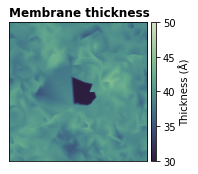

In [102]:
from lipyphilic.lib.plotting import ProjectionPlot

df = pd.read_csv("./Data_Analysis/Memb_thickness/Fatslim_localthickness/frame_00000.csv")
x_pos = df["X coords"]*10
y_pos = df["Y coords"]*10
thickness = df["Thickness"]*10

thickness_projection = ProjectionPlot(x_pos=x_pos, y_pos=y_pos, values=thickness)


# load the first frame coordaintes into memory
frame_index = -1
u.trajectory[frame_index]  

# We will create 1 x 1 Angstrom bins that covers the entire range of the system in xy
bins = np.linspace(0, u.dimensions[0], int(np.ceil(u.dimensions[0]) + 1))

thickness_projection.project_values(bins=bins)
thickness_projection.interpolate()

vmin=30
vmax=50

thickness_projection.plot_projection(
    title="Membrane thickness",
    vmin=vmin,
    vmax=vmax,
    cbar_kws={"shrink":0.85, "label": "Thickness (Å)"}  # make the colourbar smaller
)

# Add sensible tick spacing to the colourbar
thickness_projection.cbar.set_ticks(np.arange(30, 51, 5))

In [22]:
print(dens.density)

<Density density with (167, 165, 72) bins>


/home/apmlab/anaconda3/lib/python3.9/site-packages/MDAnalysis/analysis/density.py:497: DeprecationWarning: The `density` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.density` instead
  warnings.warn(wmsg, DeprecationWarning)


### 4.3 Membrane curvature

In [117]:
cutoff,N = mda.analysis.leaflet.optimize_cutoff(u, "name PO4 ROH")
L = mda.analysis.leaflet.LeafletFinder(u, 'name PO4', cutoff=cutoff)
upper_lipids = {l:(L.groups(0).resnames == l).sum() for l in np.unique(L.groups(0).resnames)}
lower_lipids = {l:(L.groups(1).resnames == l).sum() for l in np.unique(L.groups(1).resnames)}

upper_atoms = " ".join({str(i) for i in L.groups(0).resids})
lower_atoms = " ".join({str(i) for i in L.groups(1).resids})


print(f"Optimized cutoff: {cutoff} A\nNumber of leaflets:{N}\n\
Upper leaflet lipids: {list(upper_lipids)}\nLower leaflet lipids {list(lower_lipids)}")

Optimized cutoff: 14.0 A
Number of leaflets:2
Upper leaflet lipids: ['DPSM', 'PAPC', 'PAPE', 'POPC']
Lower leaflet lipids ['POPC']


MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting analysis loop over 473 trajectory frames
MDAnalysis.analysis.base: INFO     Starting analysis loop over 473 trajectory frames
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Starting analysis loop over 473 trajectory frames
MDAnalysis.analysis.base: INFO     Starting analysis loop over 473 trajectory frames
MDAnalysis.analysis.base: INFO     Finishing up
MDAnalysis.analysis.base: INFO     Finishing

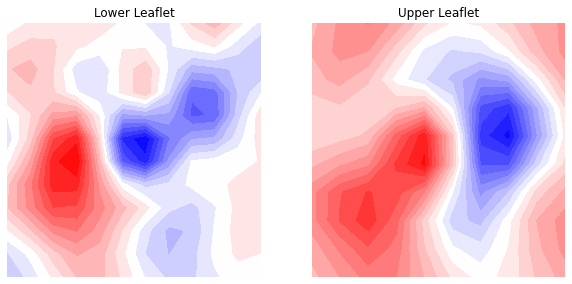

In [80]:
from membrane_curvature.base import MembraneCurvature
from scipy import ndimage

curvature_upper_leaflet = MembraneCurvature(u,
                                            select=f"resid {upper_atoms}",
                                            n_x_bins=10,
                                            n_y_bins=10, wrap=True).run()

mean_upper_leaflet = curvature_upper_leaflet.results.average_mean

curvature_lower_leaflet = MembraneCurvature(u,
                                            select=f"resid {lower_atoms}",
                                            n_x_bins=12,
                                            n_y_bins=12, wrap=True).run()


mean_lower_leaflet = curvature_lower_leaflet.results.average_mean

leaflet_names = ['Lower', 'Upper']

curvatures = [mean_lower_leaflet, mean_upper_leaflet]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
for ax, mc, lf in zip((ax1, ax2), curvatures, leaflet_names):
    arr_ = ndimage.gaussian_filter(mc, sigma=1, order=0, mode='reflect')
    ax.contourf(arr_.T,
                cmap='bwr',
                levels=30)
    ax.set_aspect('equal')
    ax.set_title('{} Leaflet'.format(lf))
    ax.axis('off')

## 5.- Calculate APL

In [82]:
upper_areas = AreaPerLipid(
  universe=u,
  lipid_sel="name AM1 AM2 GL1 GL2 ROH",  # assuming we're using the MARTINI forcefield
  leaflets= leaflets.leaflets
)

upper_areas.run(start=None, stop=None, step=None, verbose=True)
upper_areas.areas

  0%|          | 0/473 [00:00<?, ?it/s]

array([[ 50.50457501,  12.52710458,  22.88965424, ...,  51.04343596,
         30.71894969,  42.62126096],
       [ 34.21757296,  29.39291207,  31.44736685, ...,  28.10401222,
         37.4829484 ,  22.78173575],
       [ 30.57998024,  34.04703676,  32.24872365, ...,  47.02960926,
         27.55191194,  22.05449833],
       ...,
       [ 96.46465327, 120.2332474 ,  62.68362827, ..., 147.60393304,
        148.51327514, 151.11794067],
       [ 72.43184491,  76.20040754,  65.30052034, ..., 122.62180383,
        161.67931608, 167.63920615],
       [ 86.16990756,  63.79692537,  45.84768574, ...,  42.98104095,
        167.6036303 , 128.1051279 ]])

## 6.- Calculate lipid order parameter

In [105]:
#CHECK IF TAILS ARE SATURATED OR UNSATURATED FOR EACH LIPID? I did an avg of the 2 tails to avoid this
from lipyphilic.lib.order_parameter import SCC
#Calculate order lipid parameters
scc_sn1 = SCC(
  universe=u,
  tail_sel="name ??A"  # selects C1A, C2A, D2A, C3A, and C4A
)

scc_sn2 = SCC(
  universe=u,
  tail_sel="name ??B"  # selects C1B, C2B, D2B, C3B, and C4B
)
scc_sn2.run(verbose=True)
scc_sn1.run(verbose=True)

#Calculaye avg between the 2 tails: returns array of size n_lipids x n_frames
scc_avg = SCC.weighted_average(scc_sn1, scc_sn2)

print(scc_avg.SCC)

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

[[ 0.15015222  0.52005266  0.45644873 ...  0.38368262  0.03976182
   0.19064553]
 [ 0.44860431  0.3521393   0.46379279 ...  0.28350177  0.1277843
   0.31811381]
 [ 0.43166041  0.53183657  0.20009969 ...  0.26218559  0.14151495
   0.41575104]
 ...
 [ 0.20050992  0.41296375  0.37887865 ...  0.27207282  0.44955107
   0.21194587]
 [ 0.25427989  0.35253109 -0.05964335 ...  0.70321646  0.45138725
   0.23980423]
 [ 0.12728618  0.36455576 -0.25911421 ...  0.52096539  0.23516731
   0.5806046 ]]


In [110]:
#Plot CG lipid order parameters projected onto the XY membrane plane


## 7. Depletion enrichment index

In [83]:
%%time
lipid_counts = {ts.time:{lipid:0 for lipid in lipid_list} for ts in u.trajectory} #Initialize dict to store lipid counts per frame 
lipids_bulk = {lipid:len(set(u.select_atoms(f"resname {lipid}").resids)) for lipid in lipid_list} #Number of each lipid in bulk

#Iterate over traj
for ts in u.trajectory:
    for lipid in lipid_list: #Iterate over each lipid in list
        #Count nº lipids around protein for each lipid in each frame and add to dict
        lipid_counts[ts.time][lipid] = len(set(u.select_atoms(f"resname {lipid} and name GL1 AM1 ROH and around {contact_cutoff} {target}").resids))

lc_df = pd.DataFrame.from_dict(lipid_counts) #Convert dict of dict (frames[lipid:count]) to df
lb_df = pd.Series(lipids_bulk) #Convert bulk composition to data series

lc_df_ratios = lc_df.div(lc_df.sum(axis=0), axis=1) #Calculate ratio of each lipid around protein over total lipids aound prot for every frame
lb_df_ratios = lb_df/lb_df.sum() #Calculate ratios of each lipid in bulk

DE_index = lc_df_ratios.div(lb_df_ratios, axis=0) #Compute DE index


CPU times: user 46.7 s, sys: 9.94 ms, total: 46.7 s
Wall time: 46.8 s


Can't create folder: folder Analysis/DE_index already exists


/tmp/ipykernel_374735/1382744160.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')  ####### Style for the plots (defined one to keep same style accross ALL plots ########


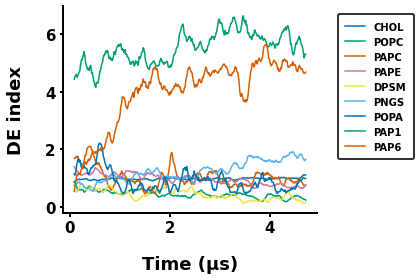

In [85]:
#Save data and basic plot
try:
    os.mkdir("Analysis/DE_index")
    print("Folder Analysis/DE_index created")
except OSError as error:
    print("Can't create folder: folder Analysis/DE_index already exists")

DE_index.T.to_csv("Analysis/DE_index/DE_index.csv") 

plot_kwargs = {"xlabel":"Time (µs)", "ylabel":"DE index"}

plt.style.use('seaborn-colorblind')  ####### Style for the plots (defined one to keep same style accross ALL plots ########


ax = DE_index.T.rolling(window=window).mean().set_index(DE_index.T.index/1000000).plot(**plot_kwargs)
sns.despine(top=True, right=True)
plt.xlabel("Time (µs)",fontsize=18, weight="bold",labelpad=20)
plt.ylabel("DE index", fontsize=18, weight="bold",labelpad=20)
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.8, borderpad=0.75, fontsize="large", edgecolor="black", prop={"weight":"bold"}).get_frame().set_linewidth(2) #Legend outside the plot
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
ax.xaxis.set_tick_params(labelsize=15)
plt.xticks(weight="bold") 
ax.yaxis.set_tick_params(labelsize=15)
plt.yticks(weight="bold") 
ax.tick_params(width=2)
plt.tight_layout()

fig = ax.get_figure()
fig.savefig("Analysis/DE_index/DE_index_fulltraj")

## 8. Pylipid

### 8.1 Residue occupancy, lipid count, Koff, residence time and binding sites

In [86]:
try:
    os.mkdir("Analysis/PyLipid")
    print("Folder Pylipid created")
except OSError as error:
    print("Can't create folder: folder Pylipid already exists")

Can't create folder: folder Pylipid already exists


In [93]:
#Loop for every lipid

#Prepare data for PyLipid module
cutoffs = [0.475, 0.8] #Must be optimized for each lipid
nprot=1
timeunit = "us"
save_dir = "./Analysis/PyLipid/"

#Initialize
li = pylipid.api.LipidInteraction(traj_file, topfile_list=top_file_2, cutoffs=cutoffs, lipid="PAP6",
                      nprot=nprot, save_dir=save_dir)

CALCULATE RESIDUE LIPIDCOUNT: 100%|███████████████████████████████████████████████| 2760/2760 [00:01<00:00, 2458.29it/s]


Creating new director: /home/apmlab/Projectes/mario/Script_devel/Analysis_scripts/Analysis/PyLipid/Interaction_PAP6/Residue_koffs_PAP6


CALCULATE KOFF FOR RESIDUES:   0%|          | 0/2760 [00:00<?, ?it/s]

CALCULATE LIPIDCOUNT PER BINDING SITE: 100%|████████████████████████████████████████████| 18/18 [00:01<00:00, 11.24it/s]

Creating new director: /home/apmlab/Projectes/mario/Script_devel/Analysis_scripts/Analysis/PyLipid/Interaction_PAP6/Binding_Sites_koffs_PAP6


CALCULATE KOFF FOR BINDING SITES:   0%|          | 0/18 [00:00<?, ?it/s]

CALCULATE BINDING SITE SURFACE AREA:   0%|          | 0/1 [00:00<?, ?it/s]

Creating new director: /home/apmlab/Projectes/mario/Script_devel/Analysis_scripts/Analysis/PyLipid/Interaction_PAP6/Bound_Poses_PAP6


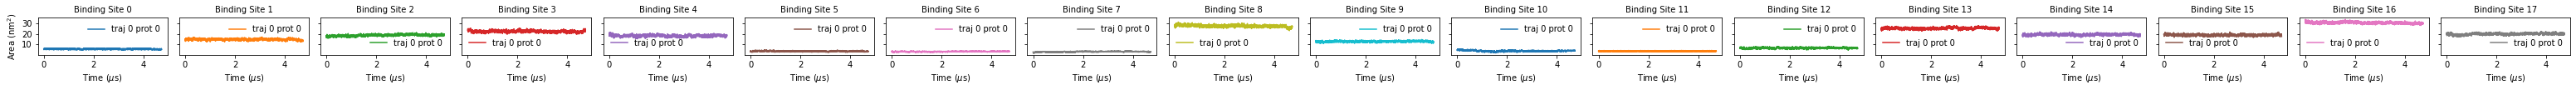

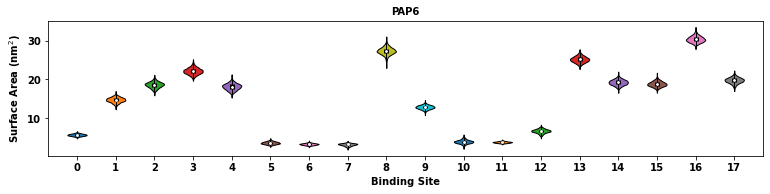

In [94]:
#Basic analysis
li.collect_residue_contacts()

#Duration, occupancy, lipidcount and koffs/restimes of residues
durations = li.compute_residue_duration()
occupancies = li.compute_residue_occupancy()
lipidcounts = li.compute_residue_lipidcount()
koffs, res_times = li.compute_residue_koff(plot_data=True, fig_close=True)

#Compute binding sites and their durations, occupancies, lipidcounts ,koffs/restimes, surface area, and poses
node_list, modularity = li.compute_binding_nodes(threshold=4, print_data=False)
durations = li.compute_site_duration()
occupancies = li.compute_site_occupancy()
lipidcounts = li.compute_site_lipidcount()
koff_BS, res_time_BS = li.compute_site_koff(plot_data=True)

surface_area = li.compute_surface_area(plot_data=True)

#Save data of the PyLipid analysis
li.dataset.to_csv(f"Data_Analysis/PyLipid/{lipid}_dataset.csv")

In [115]:
print(set(li.dataset[li.dataset["Binding Site Residence Time"] > 4]["Binding Site Residence Time"]))
li.dataset[li.dataset["Binding Site Residence Time"] > 4]

{4.726}


,Residue,Residue ID,Duration,Duration std,Occupancy,Occupancy std,Lipid Count,Lipid Count std,Koff,Residence Time,...,Binding Site ID,Binding Site Duration,Binding Site Occupancy,Binding Site Lipid Count,Binding Site Koff,Binding Site Koff Bootstrap avg,Binding Site Residence Time,Binding Site R Squared,Binding Site R Squared Bootstrap avg,Binding Site Surface Area
358,359ARG,358,0.265647,0.401480,26.253438,0.0,1.000000,0.0,1.326395,0.753923,...,4,0.157077,84.577956,1.104802,0.156233,1.107617,4.726,0.533760,0.603556,18.142889
359,360LEU,359,0.147053,0.206330,3.829067,0.0,1.000000,0.0,2.612283,0.382807,...,4,0.157077,84.577956,1.104802,0.156233,1.107617,4.726,0.533760,0.603556,18.142889
361,362SER,361,0.143615,0.228282,12.164163,0.0,1.000000,0.0,3.077066,0.324985,...,4,0.157077,84.577956,1.104802,0.156233,1.107617,4.726,0.533760,0.603556,18.142889
362,363ARG,362,0.204789,0.615206,20.499260,0.0,1.000000,0.0,0.709669,1.409107,...,4,0.157077,84.577956,1.104802,0.156233,1.107617,4.726,0.533760,0.603556,18.142889
364,365PHE,364,0.009853,0.012731,1.903956,0.0,1.000000,0.0,52.395319,0.019086,...,4,0.157077,84.577956,1.104802,0.156233,1.107617,4.726,0.533760,0.603556,18.142889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2720,651ARG,2720,0.060828,0.128751,14.025809,0.0,1.009050,0.0,2.512093,0.398074,...,17,0.069800,81.954728,1.107641,0.137127,0.418171,4.726,0.957209,0.792951,19.776749
2721,652LYS,2721,0.238130,0.789498,36.577110,0.0,1.036437,0.0,0.360133,2.776755,...,17,0.069800,81.954728,1.107641,0.137127,0.418171,4.726,0.957209,0.792951,19.776749
2722,653LYS,2722,0.241462,0.377008,15.548974,0.0,1.000000,0.0,2.115418,0.472720,...,17,0.069800,81.954728,1.107641,0.137127,0.418171,4.726,0.957209,0.792951,19.776749
2723,654HIS,2723,0.039692,0.071658,6.177279,0.0,1.006849,0.0,3.326654,0.300602,...,17,0.069800,81.954728,1.107641,0.137127,0.418171,4.726,0.957209,0.792951,19.776749


### EXTRA: Analyze bound poses (very slow)

In [68]:
#Find representative bound poses of all/selected binding sites (better check important BS to save time)
pose_pool, pose_rmsd = li.analyze_bound_poses(binding_site_id=None, pose_format="pdb",
                                             n_top_poses=3, n_clusters='auto') # None means analysis for all residues

NameError: name 'li' is not defined